# A journey into Sound.

One of the most successful applications of deep learning is something that we carry around with us every day. Whether it's Google Now, or Siri, the engines that power both systems and Amazon's Alexa are neural networks. We will take a look on ```torchaudio``` library. We will construct a pipeline for classifying audio data with a convolutional-based model.

# Sound

Sound is created via the vibration of air. All the sounds we hear are combinations of high and low pressure that we often represent in a waveform, like the one following example; the wave below above the origin is high pressure, and the part below is low pressure.

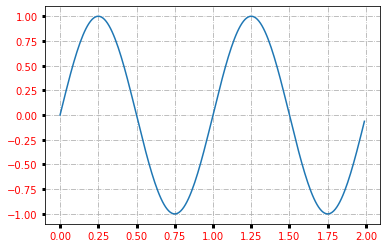

In [1]:
import matplotlib.pyplot as plt
import numpy as np

t = np.arange(0.0, 2.0, 0.01)
s = np.sin(2 * np.pi * t)

fig, ax = plt.subplots()
ax.plot(t, s)

ax.grid(True, linestyle='-.')
ax.tick_params(labelcolor='r', labelsize='medium', width=3)

plt.show()

Now let's try something more complex than a sine wave;

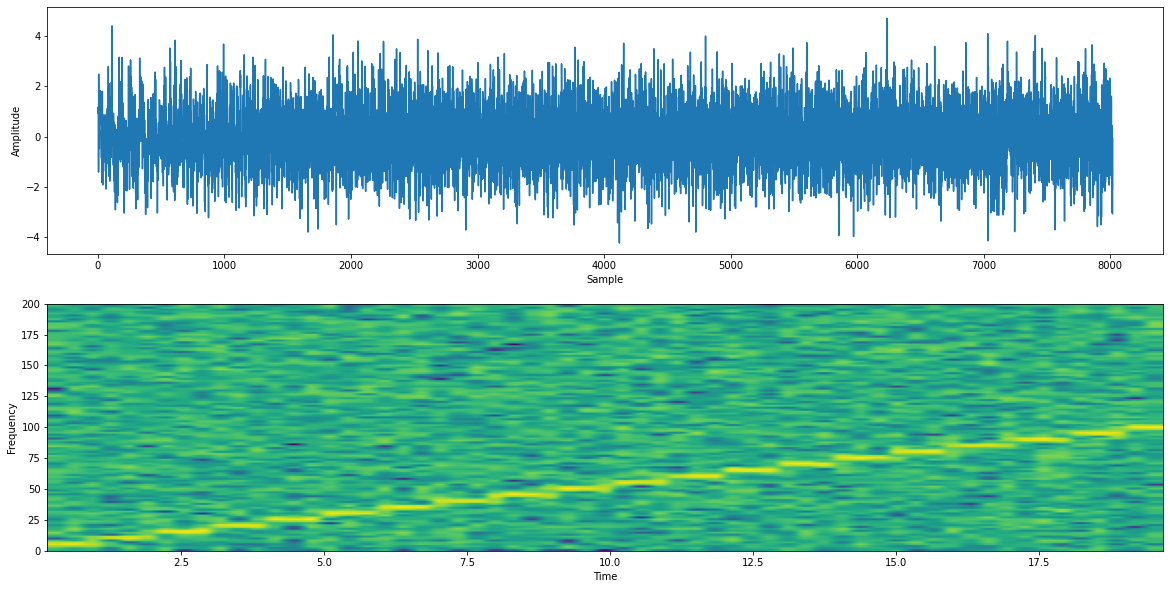

In [2]:
#Define the list of frequencies
frequencies         = np.arange(5,105,5)
# Sampling Frequency
samplingFrequency   = 400
# Create two ndarrays
s1 = np.empty([0]) # For samples
s2 = np.empty([0]) # For signal
# Start Value of the sample
start   = 1
# Stop Value of the sample
stop    = samplingFrequency+1
for frequency in frequencies:
    sub1 = np.arange(start, stop, 1)
    # Signal - Sine wave with varying frequency + Noise
    sub2 = np.sin(2*np.pi*sub1*frequency*1/samplingFrequency)+np.random.randn(len(sub1))
    s1      = np.append(s1, sub1)
    s2      = np.append(s2, sub2)
    start   = stop+1
    stop    = start+samplingFrequency

# Plot the signal
plt.figure(figsize=(20,10))
plt.subplot(211)
plt.plot(s1,s2)
plt.xlabel('Sample')
plt.ylabel('Amplitude')
# Plot the spectrogram
plt.subplot(212)
powerSpectrum, freqenciesFound, time, imageAxis = plt.specgram(s2, Fs=samplingFrequency)
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.show()   

In digital sound, we *sample* this waveform many times a second, traditionally 44,100 for CD-quality sound, and store the amplitude values of the wave during each sample point. At time $t$, we have a single value stored. This is slightly different from an image, which requires two values $x$ and $y$, to store a value (for a grayscale image). If we use convolutional filters in our neural network, we need a 1D filter rather than the 2D filters we were using for images.

Now that we know a little more about sound, let's look at the dataset we use.

#  ESC-50 Dataset

The *Environmental Sound Classification (ESC)* dataset is a collection of field recordings, each of which is 5 seconds long and assigned to one of 50 classes  (e.g., a dog barking, snoring, a knock on a door). We use this set for the rest of this experiment with two ways of classifying audio, as well as to explore using ```torchaudio``` to simplify loading and manipulating audio.

*Note: get the  dataset from https://github.com/karoldvl/ESC-50/archive/master.zip*

We care about the final number in the filename, because that tells us what class this sound clip has been assigned to. The other parts of the filename don't matter to us but mostly relate to the larger Freesound dataset from which ESC-50 has been drawn (with one exception that I'll come back to shortly). If you're interested in finding out more, the README document in the ESC-50 repo goes into further detail.

Now that we've downloaded the dataset, let's look at some of the sounds it contains.

# Playing audio in Jupyter

If you want to actually hear a sound from ESC-50, then instead of loading one of the files into a standard music player, you can use  Jupyter's built-in player for audio, ```IPython.display.Audio```

In [3]:
import IPython.display as display
display.Audio('ESC-50-master/audio/train/1-100032-A-0.wav')

# Exploring ESC-50

When dealing with a new dataset, it's always a good idea to get a feeling for the *shape* of the data before you dive right into building models. In classification tasks, for example, you'll want to know whether your dataset actually contains examples from all the possible classes, and ideally that all classes are present in equal numbers. Let's take a look how ESC-50 breaks down.

*Note: If your dataset has an **unbalanced amount of data**, a simple solution is to randomly duplicate the smaller class examples until you have increased them to the number of the other classes. Although this feels like fake accounting, it's surprisingly effective (and cheap) in practice.*

We know that the final set of digits in each filename describes the class it belongs to, so what we need to do is grab a list and count up the occurrences of each class:

In [4]:
import glob
from collections import Counter

esc50_list = sorted([f.split("-")[-1].replace(".wav", "")
             for f in glob.glob("ESC-50-master/audio/*.wav")])
counter = Counter(esc50_list)

First, we build up a list of our ESC-50 filenames. Because we care about only the class number at the end of the filename, we chop off the *.wav*  extension and split the filename in the - separator. We finally take the last element in that split string. If you inspect ```esc50_list```, you'll get a bunch of strings that range from 0 to 49. We could write more code that builds a ```dict``` and counts all the occurrences for us, but ```Counter``` does that for us taking any hashable items. Here's the output.

In [5]:
counter

Counter()

We have one of those rare things, a perfectly balanced dataset. Now install a few more libraries we're going to need.

# SoX and LibROSA

Most of the audio processing that ```torchaudio``` carries out riles on two other pieces of software: *SoX* and *LibROSA*. *LibROSA* is a Python library for audio analysis, including generating mel spectograms (Like in the 2nd example, where we graph Frequency vs Time instead of Amplitude vs Time or Samples), detecting beats, and even generating music.

*SoX*, on the other hand, is a program that you might already be familiar with if you've using linux for years.

# torchaudio

The core of ```torchaudio``` is found within ```load()``` and ```save()```. We're concerned only with ```load()``` in this example, but maybe you'll need to use ```save()``` if you're generating new audio from the input (e.g, text-to-speech model). ```load()``` takes a file specified in ```filepath``` and returns a tensor representation of the audio file and the sample rate of that audio file as a separate variable.

We now have the means for loading one of the WAV files from the ESC-50 dataset and turning it into a tensor. Unlike our earlier work with  text and images, we need to write a bit more code before we can get on with creating and training a model. We need to write a custon ```Dataset``` class.

# Building an ESC-50 Dataset

We've talked about datasets in **Chapter 2**, but ```torchvision``` and ```torchtext``` did all the heavy lifting for us, so we didn't have to worry too much about the details. As you may remember, a custom dataset has to implement two class methods, ```___getitem___``` and ```___len___```, so that the data loader can get a batch of tensors and their labels, as well as a total count of tensors in the dataset. We also have an ```___init___``` method for setting up things like file paths that'll be used over and over again.

In [6]:
import torch
import torch.nn as nn
import torchaudio
import torch.nn.functional as F
import torchaudio.transforms as T
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
class ESC50Dataset(Dataset):
    
    def __init__(self, path):
        self.path = path
        # Get the directory  listing from path
        files = Path(self.path).glob('*.wav')
        # Iterate through the listing and create  a list of tuples (filename, label)
        self.items = [(str(f), f.name.split("-")[-1].replace(".wav", "")) for f in files]
        self.length = len(self.items)
        
    def __getitem__(self, index):
        filename, label = self.items[index]
        audio_tensor, sample_rate = torchaudio.load(filename)
        return audio_tensor, int(label)
    
    def __len__(self):
        return self.length

The majority of the work in the class happens when a new instance of it is created. The ```___init___``` method takes the ```path``` parameter, finds all the WAV files inside that path, and then produces tuples of ```(filename, label)``` by using the same string split we used earlier in the chapther to get the label of that audio sample. When PyTorch reques an item from the dataset, we index into the ```items``` list, use ```torchaudio`.load``` to make ```torchaudio``` load in the audio file, turn it into a tensor, and then return both the tensor and the label.

And that's enough for us to start with. For a sanity check, let's create an ```ESC50Dataset``` object and extract the first item:

In [7]:
PATH_TO_ESC50 = Path.cwd() / 'ESC-50-master/audio/'
test_esc50 = ESC50Dataset(PATH_TO_ESC50/ 'train/')
tensor, label = list(test_esc50)[0]
tensor

tensor([[-0.0022, -0.0022, -0.0010,  ...,  0.0000,  0.0000,  0.0000]])

In [8]:
tensor.shape

torch.Size([1, 220500])

In [9]:
label

20

We can construct a data loader by using PyTorch standard constructs:

In [10]:
example_loader = DataLoader(test_esc50, batch_size=64, shuffle=True)

Before we construct our ```DataLoader``` instances for ```train, valid, test``` sets, we have to go back into our data. As you might remember, we should always create a training, validation and test sets. At the moment, we have just one directory with all the data, which is no good for our purposes. A 60/20/20 split of data into training, validation and test collections should suffice. Now, we could do this by taking random samples of our entire dataset (taking care to sample without replacement and making sure that our newly constructed datasets are still balanced), but again the ESC-50 dataset saves us from having to do much work. The compilers of the dataset separated the data into five equal balanced *folds* indicated by the *first* digit in the filename. We'll have folds ```1,2,3``` be the training set, ```4``` validation set, and ```5``` the test set:

Do:

```mkdir train test valid
mv 1*  .../train
mv 2*  .../train
mv 3*  .../train
mv 4*  .../valid
mv 5*  .../test
```

Now we can create the individual datasets and loaders:


In [11]:
batch_size = 24
device = 'cuda'
train_esc50 = ESC50Dataset(PATH_TO_ESC50 / 'train')
valid_esc50 = ESC50Dataset(PATH_TO_ESC50 / 'valid')
test_esc50 = ESC50Dataset(PATH_TO_ESC50 / 'test')

train_loader = DataLoader(train_esc50, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_esc50, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_esc50, batch_size=batch_size, shuffle=True)

# A CNN Model for ESC-50

For our first attempt at classifying sounds, we build a a model that borrows heavily from a paper called "Very Deep Convolutional Networks for Raw Waveforms". It uses a lot of building blocks from Chapter 3, but instead of using 2D layers, we're using 1D variants as we have one fewer dimension in our audio inputs:

In [12]:
class AudioNet(nn.Module):
    
    def __init__(self):
        super(AudioNet, self).__init__()
        self.conv1 =  nn.Conv1d(100, 128, kernel_size=5, stride=4)
        self.bn1 = nn.BatchNorm1d(128)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(128, 128, 3)
        self.bn2 = nn.BatchNorm1d(128)
        self.pool2 = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(128, 256, 3)
        self.bn3 = nn.BatchNorm1d(256)
        self.pool3 = nn.MaxPool1d(4)
        self.conv4 = nn.Conv1d(256, 512, 3)
        self.bn4 = nn.BatchNorm1d(512)
        self.pool4 = nn.MaxPool1d(4)
        self.fc1 = nn.Linear(512, 50)
        
    def forward(self, x):
        x = x.unsqueeze(-1).view(-1, 100, 2205)
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)
        x = x.squeeze(-1)
        x = self.fc1(x)
        return x

In [13]:
audionet = AudioNet()
audionet.to(device)

AudioNet(
  (conv1): Conv1d(100, 128, kernel_size=(5,), stride=(4,))
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(128, 128, kernel_size=(3,), stride=(1,))
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(128, 256, kernel_size=(3,), stride=(1,))
  (bn3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(256, 512, kernel_size=(3,), stride=(1,))
  (bn4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=512, out_features=50, 

In [14]:
def find_lr(model, loss_fn, optimizer, train_loader, init_value=1e-8, final_value=10.0, device="cpu"):
    number_in_epoch = len(train_loader) - 1
    update_step = (final_value / init_value) ** (1 / number_in_epoch)
    lr = init_value
    optimizer.param_groups[0]["lr"] = lr
    best_loss = 0.0
    batch_num = 0
    losses = []
    log_lrs = []
    for data in train_loader:
        batch_num += 1
        inputs, targets = data
        inputs = inputs.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)

        # Crash out if loss explodes

        if batch_num > 1 and loss > 4 * best_loss:
            if(len(log_lrs) > 20):
                return log_lrs[10:-5], losses[10:-5]
            else:
                return log_lrs, losses

        # Record the best loss

        if loss < best_loss or batch_num == 1:
            best_loss = loss

        # Store the values
        losses.append(loss.item())
        log_lrs.append((lr))

        # Do the backward pass and optimize

        loss.backward()
        optimizer.step()

        # Update the lr for the next step and store

        lr *= update_step
        optimizer.param_groups[0]["lr"] = lr
    if(len(log_lrs) > 20):
        return log_lrs[10:-5], losses[10:-5]
    else:
        return log_lrs, losses

In [15]:
torch.save(audionet.state_dict(), 'audionet.pth')

In [16]:
optimizer = torch.optim.Adam(audionet.parameters(), lr=0.001)
logs, losses = find_lr(audionet, nn.CrossEntropyLoss(), optimizer, train_loader, device=device)

/home/leno/.local/share/virtualenvs/PyTorch-Im_YsN3d/lib/python3.9/site-packages/torch/nn/functional.py:652: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [22]:
def get_index_min(logs, losses):
    # Returns a tuple of the corresponding learning rate with the min loss
    min_loss = min(losses)
    min_loss_index = losses.index(min_loss)
    return min_loss, logs[min_loss_index]

In [26]:
min_loss, opt_log = get_index_min(logs, losses)

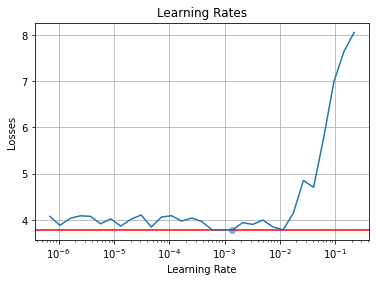

In [34]:
fig, ax = plt.subplots()
ax.scatter(opt_log, min_loss, alpha=0.5)
ax.axhline(y=min_loss, color='r')
ax.semilogx(logs, losses)
ax.set(xlabel='Learning Rate', ylabel='Losses',
       title='Learning Rates')
ax.grid()
plt.show()